In [2]:
#basic package
import os
import numpy as np
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import math
import pickle #save and load dictionaries/lists
import random
import tqdm

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
import config_origins as config

In [4]:
name = 'OFH'

# Define parameters

In [6]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
max_date_adaptability = config.max_date_adaptability

change the configuration file if not done yet!


# Download data

In [5]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
#display(df_daily[df_daily.isna().any(axis=1)])
#make sure we have their mvt
df_daily = df_daily[~df_daily['perc_duration_5_Zone'].isnull()]
dico_cl = {'MEXP':'MEXP','LEXP':'LEXP',
           'EPI':'REXP','LEXPLOST':'REXP','MEXPLOST':'REXP','NewAfterEpiLOST':'REXP','NewAfterEpi':'REXP'}
df_daily['CLASS'] = df_daily['CLASS'].map(lambda x: dico_cl[x])
display(df_daily['CLASS'].value_counts())
#show columns with max amount of nan
display(df_daily.isna().sum(axis=0).sort_values())
print(df_daily.shape)
display(df_daily.head(3))
print(min(df_daily['WOA'].tolist()), max(df_daily['WOA'].tolist()))
df_doa = df_daily[['level','DIB','WIB','DOA','WOA']].drop_duplicates()
df_doa.sort_values(['level']).head(10)

REXP    22762
MEXP     9174
LEXP     7446
Name: CLASS, dtype: int64

HenID                                                0
nbr_stays_4_Zone                                     0
nbr_stays_5_Zone                                     0
nbr_stays_2_Zone                                     0
PenID                                                0
                                                 ...  
mid_cum_Z4_sec_Morning                            5991
vertical_travel_distance_fulllight_perinsideh     6608
R-Pen                                            11034
FirstTimestamp_1_Zone_sec                        14495
FirstTimestamp_1_Zone                            14495
Length: 82, dtype: int64

(39382, 82)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,weight_interp,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday
0,hen_130,2020-10-05,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",0.0,0.0,100.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.00,0.000000,540.000000,True
1,hen_130,2020-10-06,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",2.0,1.0,97.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,13.00,5.416667,521.583333,False
2,hen_130,2020-10-07,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",1.0,0.0,98.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,3.433333,4.15,2.166667,530.250000,False


17 60


,level,DIB,WIB,DOA,WOA
3,2020-09-30,1,1,119,17
4,2020-10-01,2,1,120,18
5,2020-10-02,3,1,121,18
14850,2020-10-03,4,1,122,18
6,2020-10-04,5,1,123,18
0,2020-10-05,6,1,124,18
1,2020-10-06,7,1,125,18
2,2020-10-07,8,2,126,18
10,2020-10-10,11,2,129,19
11,2020-10-11,12,2,130,19


#weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

In [6]:
li = ['HenID','PenID','level','Treatment', 'CLASS', 'DOA','WOA', 'DIB','WIB']
df_daily[li+['perc_duration_1_Zone','perc_duration_2_Zone','perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone']]

,HenID,PenID,level,Treatment,CLASS,DOA,WOA,DIB,WIB,perc_duration_1_Zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
0,hen_130,pen10,2020-10-05,TRAN,REXP,124,18,6,1,NaN,0.0,0.0,0.0,100.0
1,hen_130,pen10,2020-10-06,TRAN,REXP,125,18,7,1,NaN,0.0,2.0,1.0,97.0
2,hen_130,pen10,2020-10-07,TRAN,REXP,126,18,8,2,NaN,1.0,1.0,0.0,98.0
3,hen_131,pen10,2020-09-30,TRAN,REXP,119,17,1,1,NaN,85.0,15.0,0.0,0.0
4,hen_131,pen10,2020-10-01,TRAN,REXP,120,18,2,1,NaN,69.0,18.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39377,hen_98,pen9,2021-07-20,OFH,MEXP,412,59,294,42,12.0,45.0,8.0,12.0,23.0
39378,hen_98,pen9,2021-07-21,OFH,MEXP,413,59,295,43,7.0,56.0,11.0,7.0,20.0
39379,hen_98,pen9,2021-07-22,OFH,MEXP,414,60,296,43,15.0,45.0,11.0,8.0,22.0
39380,hen_98,pen9,2021-07-23,OFH,MEXP,415,60,297,43,18.0,42.0,12.0,10.0,17.0


In [7]:
df_daily.isna().sum(axis=0).sort_values().tail(30)

SleepingHeight                                     450
night_duration_Z5                                  450
FirstTimestamp_4_Zone                              642
mid_cum_Z4_sec                                     642
FirstTimestamp_3_Zone                              730
weight_interp                                      871
FirstTimestamp_2_Zone                             1027
FirstTimestamp_5_Zone                             1307
FeatherDamage_interp                              1350
duration_1_Zone_min                               1714
latency_1_Zone_h                                  1714
nbr_stays_1_Zone                                  1714
perc_1_Zone_while_WG_open                         1714
perc_duration_1_Zone                              1714
nestboxes_related_behavior                        4400
food_sameDurTiming_r50_AB_final                   5851
food_sameDurTiming_r50_AP_final                   5851
food_sameDurTiming_r50_final                      5851
vertical_t

#add external temperature as environmental factor
#check variation over the day... exist very much
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x: dt.datetime.date(x))
df_wday = df_weather_h[df_weather_h['hour'].isin([11,12,13,14,15,16])].groupby(['date'])['temperature_C'].agg(lambda x: list(x)).reset_index()
df_wday['temperature_C_avg'] = df_wday['temperature_C'].map(lambda x: np.mean(x))
display(df_wday.head(3))

print(df_daily.shape)
df_daily['date'] = df_daily['level'].map(lambda x: dt.datetime.date(x))
df_daily = pd.merge(df_daily, df_wday, on='date', how='left')
print(df_daily.shape)
df_daily.head(2)

In [8]:
print(df_daily.columns)

Index(['HenID', 'level', 'verification_daily_total_duration',
       'verification_daily_total_nbr_hour', 'dur_values',
       'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone',
       'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec',
       'duration_sincedaystarted_beforeWGopened_sec',
       'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone',
       'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
       'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen',
       'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone',
       'list_of_durations', 'nestboxes_related_behavior', 'mid_cum_Z4_sec',
       'Total_number_transition', 'nbr_stays', 'distribution_entropy',
       'vertical_travel_distance', 'vertical_travel_distance_dawn',
       'vertical_travel_distance_dusk', 'nbr_stays_total', 'nbr_stays_3_Zone',
       'nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'nbr_stays_2_Zone',
       'nbr_stays_1_Zone', 'PenID', 'CLASS'

(844, 60)


HA3    176
HA4    176
HA1    175
HA2    160
HA5    157
Name: HAID, dtype: int64

,HAID,date,WOA,DOA,HenID
0,HA1,2020-11-23,25.0,173.0,175
1,HA2,2021-01-04,31.0,215.0,160
2,HA3,2021-02-01,35.0,243.0,176
3,HA4,2021-04-12,45.0,313.0,176
4,HA5,2021-07-25,60.0,417.0,157


(844, 60)


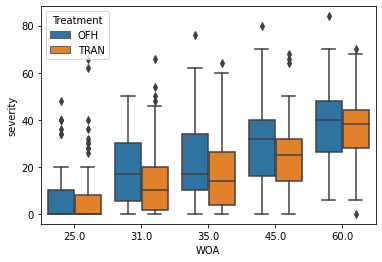

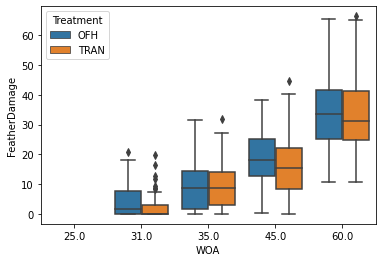

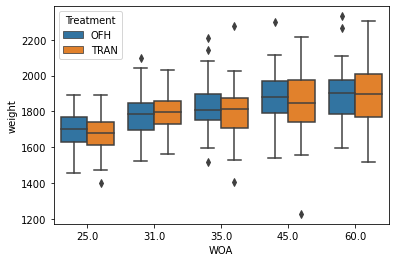

HenID              0
PenID              0
Treatment          0
DOA                0
WOA                0
CLASS              0
date               0
severity           0
FeatherDamage    181
dtype: int64

In [7]:
#KBF&severity: and save directly
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
df_HA['date_HA'] = df_HA['date'].copy()
df_HA = df_HA[~df_HA['HenID'].isnull()] #two isntances
print(df_HA.shape)
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HA['HAID'].value_counts())
#info on date
display(df_HA.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HA.shape)
df_HA.head(3)
sns.boxplot(x='WOA',y='severity', data=df_HA, hue='Treatment');
plt.show()
sns.boxplot(x='WOA',y='FeatherDamage', data=df_HA, hue='Treatment');
plt.show()
sns.boxplot(x='WOA',y='weight', data=df_HA, hue='Treatment');
plt.show()
df_save = df_HA[['HenID','PenID','Treatment','DOA','WOA','CLASS','date','severity','FeatherDamage']].copy()
df_save.to_csv(os.path.join(path_extracted_data,'OFH_df_HA.csv'), index=False, sep=',')
df_save.isna().sum(axis=0).sort_values().tail(30)

In [8]:
#check animals with 0 fractures throught recorded life
df_ = df_HA.groupby(['HenID'])['severity'].agg(lambda x: list(x)).reset_index()
df_['NOKBF'] = df_['severity'].map(lambda x: sum(x)==0) #& len(x)>3
display(df_['NOKBF'].value_counts())
display(df_.head(3))
display(df_[df_['NOKBF']])
#check animals with 0 fractures at HA 5
df_ = df_HA[df_HA['HAID']=='HA5']
df_.sort_values('severity')[['HenID','HAID','severity','has_gap']].head(15)
#152/157*100 = 96.8

False    201
True       9
Name: NOKBF, dtype: int64

,HenID,severity,NOKBF
0,hen_1,"[20, 24, 44]",False
1,hen_10,"[30, 40, 38, 34, 32]",False
2,hen_100,[0],True


,HenID,severity,NOKBF
2,hen_100,[0],True
34,hen_135,"[0, 0, 0]",True
70,hen_173,"[0, 0, 0, 0, 0]",True
144,hen_39,"[0, 0, 0]",True
152,hen_46,[0],True
160,hen_53,[0],True
178,hen_70,[0],True
182,hen_74,[0],True
201,hen_91,[0],True


,HenID,HAID,severity,has_gap
366,hen_173,HA5,0,0.0
198,hen_190,HA5,6,0.0
162,hen_226,HA5,6,0.0
380,hen_143,HA5,6,0.0
64,hen_171,HA5,8,0.0
395,hen_24,HA5,10,0.0
412,hen_153,HA5,10,0.0
641,hen_192,HA5,10,0.0
361,hen_15,HA5,10,0.0
47,hen_69,HA5,10,0.0


# Save dataframe for Dirichlet model on proportion of time in  indoor zones 

In [10]:
def indoor_zone_4_dirichelet(li, li_name):
    '''output a list that sum to one but none is 0'''
    #small checK that list are of same size:
    if len(li)!=len(li_name):
        print('ERROR: the name and value lists must have same length')
        sys.exit()
    
    s = sum(li)
    li_prop = [round(max(i/s,0.0001),6) for i in li] 
    #if it does not sum to 1, then take the largest value (if two equal, then take the first one), and replace by what it needs
    #to be summed to 1. largest value is chosen as a chane in the largest value is less important than in the smallest value &
    #also because their is no risk to have a value falling back to 0 that way!
    if sum(li_prop)!=1:
        ind_ = li_prop.index(max(li_prop))
        li_prop[ind_] = 1-(sum(li_prop)-max(li_prop)) #dont round as anyway we cant round later!
    return dict(zip(li_name,li_prop))
#small test
indoor_zone_4_dirichelet([47,20,30,20],li_name=['Z2','Z3','Z4','Z5'])
#{'Z2': 0.4017094017094017,'Z3': 0.17094017094017094,'Z4': 0.2564102564102564,'Z5': 0.17094017094017094}

{'Z2': 0.40171, 'Z3': 0.17094, 'Z4': 0.25641, 'Z5': 0.17094}

In [11]:
#only for a quick check and efficient usage of "map" (e.g. when checking how many times we had 0s)
df_daily['dico_indoorZ_prop'] = df_daily.apply(lambda x: indoor_zone_4_dirichelet(li=[x['perc_duration_2_Zone'],x['perc_duration_3_Zone'],
                                                                                      x['perc_duration_4_Zone'],x['perc_duration_5_Zone']],
                                                                                  li_name=['Z2','Z3','Z4','Z5']), axis=1)
df_daily[['dico_indoorZ_prop','perc_duration_1_Zone','perc_duration_2_Zone','perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone']]

,dico_indoorZ_prop,perc_duration_1_Zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
0,"{'Z2': 0.0001, 'Z3': 0.0001, 'Z4': 0.0001, 'Z5...",NaN,0.0,0.0,0.0,100.0
1,"{'Z2': 0.0001, 'Z3': 0.02, 'Z4': 0.01, 'Z5': 0...",NaN,0.0,2.0,1.0,97.0
2,"{'Z2': 0.01, 'Z3': 0.01, 'Z4': 0.0001, 'Z5': 0...",NaN,1.0,1.0,0.0,98.0
3,"{'Z2': 0.8498, 'Z3': 0.15, 'Z4': 0.0001, 'Z5':...",NaN,85.0,15.0,0.0,0.0
4,"{'Z2': 0.69687, 'Z3': 0.181818, 'Z4': 0.0001, ...",NaN,69.0,18.0,0.0,12.0
...,...,...,...,...,...,...
39377,"{'Z2': 0.5113629999999999, 'Z3': 0.090909, 'Z4...",12.0,45.0,8.0,12.0,23.0
39378,"{'Z2': 0.595745, 'Z3': 0.117021, 'Z4': 0.07446...",7.0,56.0,11.0,7.0,20.0
39379,"{'Z2': 0.523256, 'Z3': 0.127907, 'Z4': 0.09302...",15.0,45.0,11.0,8.0,22.0
39380,"{'Z2': 0.518518, 'Z3': 0.148148, 'Z4': 0.12345...",18.0,42.0,12.0,10.0,17.0


In [12]:
df_daily['propindoor_duration_2_Zone'] = df_daily['dico_indoorZ_prop'].map(lambda x: x['Z2'])
df_daily['propindoor_duration_3_Zone'] = df_daily['dico_indoorZ_prop'].map(lambda x: x['Z3'])
df_daily['propindoor_duration_4_Zone'] = df_daily['dico_indoorZ_prop'].map(lambda x: x['Z4'])
df_daily['propindoor_duration_5_Zone'] = df_daily['dico_indoorZ_prop'].map(lambda x: x['Z5'])

In [13]:
#check sum =1
df_daily['sum_prop'] = df_daily.apply(lambda x: x['propindoor_duration_2_Zone']+x['propindoor_duration_3_Zone']+x['propindoor_duration_4_Zone']+x['propindoor_duration_5_Zone'], axis=1)
display(df_daily[df_daily['sum_prop']!=1.0])
#check non is 0
display(df_daily[df_daily['propindoor_duration_2_Zone']==0])
display(df_daily[df_daily['propindoor_duration_3_Zone']==0])
display(df_daily[df_daily['propindoor_duration_4_Zone']==0])
display(df_daily[df_daily['propindoor_duration_5_Zone']==0])
print(df_daily['sum_prop'].max())
df_daily[df_daily['sum_prop']!=1.0]['sum_prop'].iloc[0]

,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,dico_indoorZ_prop,propindoor_duration_2_Zone,propindoor_duration_3_Zone,propindoor_duration_4_Zone,propindoor_duration_5_Zone,sum_prop
6,hen_131,2020-10-04,32400.0,9.0,"[0.0, 17244.0, 7535.0, 2283.0, 5338.0]",23.0,7.0,16.0,53.0,NaN,...,125.583333,38.050000,88.966667,False,"{'Z2': 0.5353540000000001, 'Z3': 0.232323, 'Z4...",0.535354,0.232323,0.070707,0.161616,1.0
19,hen_131,2020-10-21,39600.0,11.0,"[666.0, 23308.0, 12461.0, 3165.0, 0.0]",31.0,8.0,0.0,59.0,2.0,...,207.683333,52.750000,0.000000,False,"{'Z2': 0.6019399999999999, 'Z3': 0.316327, 'Z4...",0.601940,0.316327,0.081633,0.000100,1.0
24,hen_131,2020-10-26,43200.0,12.0,"[2373.0, 22677.0, 15270.0, 2880.0, 0.0]",35.0,7.0,0.0,52.0,5.0,...,254.500000,48.000000,0.000000,False,"{'Z2': 0.5530919999999999, 'Z3': 0.37234, 'Z4'...",0.553092,0.372340,0.074468,0.000100,1.0
25,hen_131,2020-10-27,43200.0,12.0,"[2258.0, 19888.0, 16978.0, 3204.0, 872.0]",39.0,7.0,2.0,46.0,5.0,...,282.966667,53.400000,14.533333,False,"{'Z2': 0.48936100000000016, 'Z3': 0.414894, 'Z...",0.489361,0.414894,0.074468,0.021277,1.0
46,hen_131,2020-11-17,54000.0,15.0,"[0.0, 17861.0, 28941.0, 2226.0, 4972.0]",54.0,4.0,9.0,33.0,0.0,...,482.350000,37.100000,82.866667,False,"{'Z2': 0.33, 'Z3': 0.5399999999999998, 'Z4': 0...",0.330000,0.540000,0.040000,0.090000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39340,hen_98,2021-05-23,54000.0,15.0,"[2925.0, 26094.0, 8730.0, 7159.0, 9092.0]",16.0,13.0,17.0,48.0,5.0,...,145.500000,119.316667,151.533333,False,"{'Z2': 0.5106379999999998, 'Z3': 0.170213, 'Z4...",0.510638,0.170213,0.138298,0.180851,1.0
39346,hen_98,2021-05-29,54000.0,15.0,"[3117.0, 24955.0, 7222.0, 7789.0, 10917.0]",13.0,14.0,20.0,46.0,6.0,...,120.366667,129.816667,181.950000,False,"{'Z2': 0.4946229999999998, 'Z3': 0.139785, 'Z4...",0.494623,0.139785,0.150538,0.215054,1.0
39363,hen_98,2021-07-06,54000.0,15.0,"[6369.0, 24868.0, 3765.0, 8940.0, 10058.0]",7.0,17.0,19.0,46.0,12.0,...,62.750000,149.000000,167.633333,False,"{'Z2': 0.5168539999999998, 'Z3': 0.078652, 'Z4...",0.516854,0.078652,0.191011,0.213483,1.0
39365,hen_98,2021-07-08,54000.0,15.0,"[5687.0, 25120.0, 8144.0, 5857.0, 9192.0]",15.0,11.0,17.0,47.0,11.0,...,135.733333,97.616667,153.200000,False,"{'Z2': 0.5222220000000001, 'Z3': 0.166667, 'Z4...",0.522222,0.166667,0.122222,0.188889,1.0


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,dico_indoorZ_prop,propindoor_duration_2_Zone,propindoor_duration_3_Zone,propindoor_duration_4_Zone,propindoor_duration_5_Zone,sum_prop


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,dico_indoorZ_prop,propindoor_duration_2_Zone,propindoor_duration_3_Zone,propindoor_duration_4_Zone,propindoor_duration_5_Zone,sum_prop


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,dico_indoorZ_prop,propindoor_duration_2_Zone,propindoor_duration_3_Zone,propindoor_duration_4_Zone,propindoor_duration_5_Zone,sum_prop


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,dico_indoorZ_prop,propindoor_duration_2_Zone,propindoor_duration_3_Zone,propindoor_duration_4_Zone,propindoor_duration_5_Zone,sum_prop


1.0000000000000002


1.0000000000000002

In [14]:
df_daily[li+['dico_indoorZ_prop','perc_duration_1_Zone','perc_duration_2_Zone','perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone',
            'propindoor_duration_2_Zone','propindoor_duration_3_Zone', 'propindoor_duration_4_Zone', 'propindoor_duration_5_Zone']]

,HenID,PenID,level,Treatment,CLASS,DOA,WOA,DIB,WIB,dico_indoorZ_prop,perc_duration_1_Zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,propindoor_duration_2_Zone,propindoor_duration_3_Zone,propindoor_duration_4_Zone,propindoor_duration_5_Zone
0,hen_130,pen10,2020-10-05,TRAN,REXP,124,18,6,1,"{'Z2': 0.0001, 'Z3': 0.0001, 'Z4': 0.0001, 'Z5...",NaN,0.0,0.0,0.0,100.0,0.000100,0.000100,0.000100,0.999700
1,hen_130,pen10,2020-10-06,TRAN,REXP,125,18,7,1,"{'Z2': 0.0001, 'Z3': 0.02, 'Z4': 0.01, 'Z5': 0...",NaN,0.0,2.0,1.0,97.0,0.000100,0.020000,0.010000,0.969900
2,hen_130,pen10,2020-10-07,TRAN,REXP,126,18,8,2,"{'Z2': 0.01, 'Z3': 0.01, 'Z4': 0.0001, 'Z5': 0...",NaN,1.0,1.0,0.0,98.0,0.010000,0.010000,0.000100,0.979900
3,hen_131,pen10,2020-09-30,TRAN,REXP,119,17,1,1,"{'Z2': 0.8498, 'Z3': 0.15, 'Z4': 0.0001, 'Z5':...",NaN,85.0,15.0,0.0,0.0,0.849800,0.150000,0.000100,0.000100
4,hen_131,pen10,2020-10-01,TRAN,REXP,120,18,2,1,"{'Z2': 0.69687, 'Z3': 0.181818, 'Z4': 0.0001, ...",NaN,69.0,18.0,0.0,12.0,0.696870,0.181818,0.000100,0.121212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39377,hen_98,pen9,2021-07-20,OFH,MEXP,412,59,294,42,"{'Z2': 0.5113629999999999, 'Z3': 0.090909, 'Z4...",12.0,45.0,8.0,12.0,23.0,0.511363,0.090909,0.136364,0.261364
39378,hen_98,pen9,2021-07-21,OFH,MEXP,413,59,295,43,"{'Z2': 0.595745, 'Z3': 0.117021, 'Z4': 0.07446...",7.0,56.0,11.0,7.0,20.0,0.595745,0.117021,0.074468,0.212766
39379,hen_98,pen9,2021-07-22,OFH,MEXP,414,60,296,43,"{'Z2': 0.523256, 'Z3': 0.127907, 'Z4': 0.09302...",15.0,45.0,11.0,8.0,22.0,0.523256,0.127907,0.093023,0.255814
39380,hen_98,pen9,2021-07-23,OFH,MEXP,415,60,297,43,"{'Z2': 0.518518, 'Z3': 0.148148, 'Z4': 0.12345...",18.0,42.0,12.0,10.0,17.0,0.518518,0.148148,0.123457,0.209877


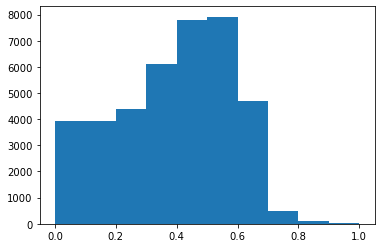

In [15]:
plt.hist(df_daily['propindoor_duration_2_Zone']);

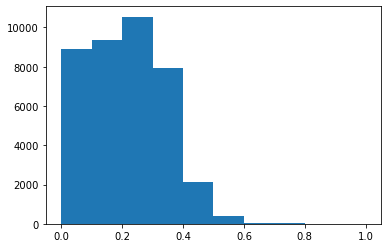

In [16]:
plt.hist(df_daily['propindoor_duration_3_Zone']);

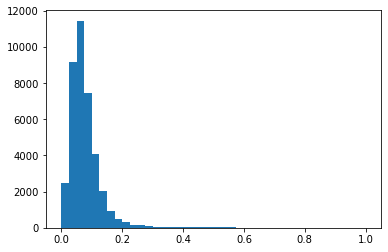

In [17]:
plt.hist(df_daily['propindoor_duration_4_Zone'], bins=40);

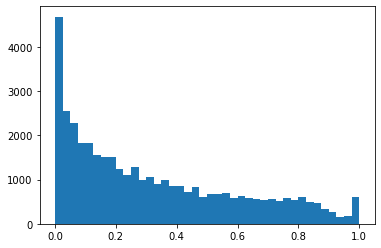

In [18]:
plt.hist(df_daily['propindoor_duration_5_Zone'], bins=40);

#select subset of random hens to start with
random.seed(12345)
li_hen = list(df_daily[df_daily['Treatment']=='OFH']['HenID'].unique())
li_hen_selected_OFH = random.sample(li_hen, 40)
li_hen = list(df_daily[df_daily['Treatment']=='TRAN']['HenID'].unique())
li_hen_selected_TRAN = random.sample(li_hen, 40)
li_hen_selected = li_hen_selected_OFH+li_hen_selected_TRAN
print(len(li_hen_selected))
#df_save = df_daily[(df_daily['weekday']=='sunday')&(df_daily['HenID'].isin(li_hen_selected))].copy()

In [19]:
#save only sundays
li_var = ['HenID', 'PenID', 'level', 'Treatment', 'CLASS', 'DOA', 'WOA', 'DIB', 'WIB',
          'KBF_interp','FeatherDamage_interp', 'weight_interp',
          'propindoor_duration_2_Zone','propindoor_duration_3_Zone', 'propindoor_duration_4_Zone', 'propindoor_duration_5_Zone']
df_save = df_daily[(df_daily['weekday']=='sunday')][li_var].copy()
print(df_save.shape)
df_save.to_csv(os.path.join(path_extracted_data, name+'_df_MVT_ALL.csv'), index=False, sep=',')

(5875, 16)


In [20]:
df_save.isna().sum(axis=0).sort_values().tail(30)
#wont mode with Feather damage

HenID                           0
PenID                           0
level                           0
Treatment                       0
CLASS                           0
DOA                             0
WOA                             0
DIB                             0
WIB                             0
propindoor_duration_2_Zone      0
propindoor_duration_3_Zone      0
propindoor_duration_4_Zone      0
propindoor_duration_5_Zone      0
KBF_interp                     40
weight_interp                 132
FeatherDamage_interp          205
dtype: int64

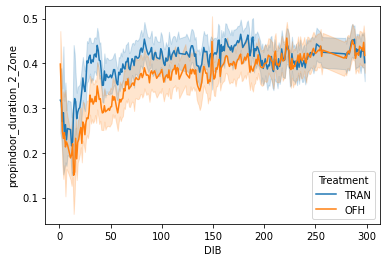

In [23]:
sns.lineplot(x='DIB', y='propindoor_duration_2_Zone', hue='Treatment', data=df_daily);

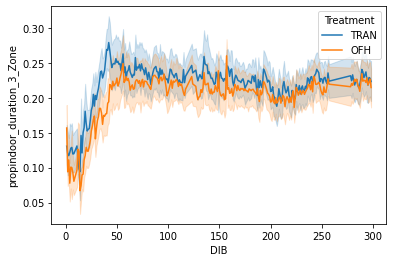

In [24]:
sns.lineplot(x='DIB', y='propindoor_duration_3_Zone', hue='Treatment', data=df_daily);

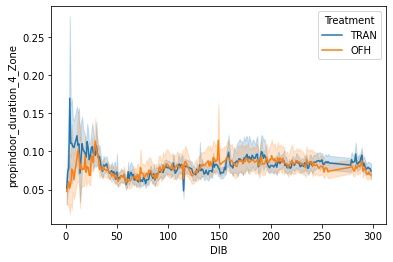

In [25]:
sns.lineplot(x='DIB', y='propindoor_duration_4_Zone', hue='Treatment', data=df_daily);

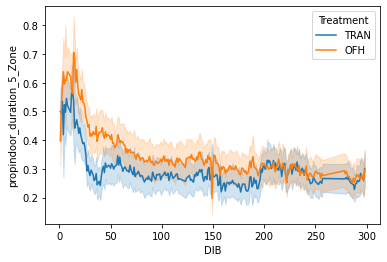

In [26]:
sns.lineplot(x='DIB', y='propindoor_duration_5_Zone', hue='Treatment', data=df_daily);

# Save dataframe for growth curve

In [27]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';', parse_dates=['InitialStartDate'])
df_FB['early_death'] = df_FB['early_death'].fillna(0).replace(2,1) #2 means not sure
display(df_FB['early_death'].value_counts())
print(df_FB.shape)
df_FB.head(3)

0.0    222
1.0     10
Name: early_death, dtype: int64

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


df_FB['12 juin weight'] = df_FB.apply(lambda x: x['10-12 juin weight'] if x['InitialStartDate']==dt.datetime(2020,6,12) else np.nan, axis=1)
df_FB['10 juin weight'] = df_FB.apply(lambda x: x['10-12 juin weight'] if x['InitialStartDate']==dt.datetime(2020,6,10) else np.nan, axis=1)
df_FB[['12 juin weight','10 juin weight','10-12 juin weight']]
#we did not weight them on the 12th!
df_FB[df_FB['InitialStartDate']==dt.datetime(2020,6,12)]

In [28]:
df_FB['InitialStartDate'].value_counts()

2020-06-10    133
2020-11-23     18
2020-06-12     17
2021-04-12     17
2021-02-01     16
2020-10-08     15
2020-09-29     10
2020-10-13      1
2020-10-20      1
2020-10-30      1
2021-02-08      1
2021-02-22      1
2020-06-17      1
Name: InitialStartDate, dtype: int64

In [29]:
#save file for OFH chapter to use in R to fit growth curve
df_FB['PenID'] = df_FB['PenID'].map(lambda x: 'pen_'+str(x))
df_FB['PenID'].unique()

array(['pen_9', 'pen_11', 'pen_5', 'pen_3', 'pen_12', 'pen_4', 'pen_8',
       'pen_10'], dtype=object)

In [30]:
li_weight = [i for i in df_FB.columns if ('weight' in i)]
print(li_weight)
df_FB_ = pd.melt(df_FB, id_vars=['HenID','Treatment','CLASS','PenID','R-Pen'], value_vars=li_weight, value_name = 'weight')
df_FB_.head(3)

['29-09 weight', '10-12 juin weight', 'weight 23-11-2020', 'weight 04-01-2021', 'weight 01-02-21', 'weight 12-04-21', 'weight 26-07-21']


,HenID,Treatment,CLASS,PenID,R-Pen,variable,weight
0,hen_1,OFH,EPI,pen_9,1.0,29-09 weight,1134.0
1,hen_10,OFH,LEXP,pen_11,1.0,29-09 weight,1070.0
2,hen_100,OFH,EPI,pen_5,3.0,29-09 weight,1182.0


In [31]:
dico_name_date = {'29-09 weight':dt.datetime(2020,9,29), 
                  '10-12 juin weight':dt.datetime(2020,6,10), #we did not weight them on the 12th!
                  'weight 23-11-2020':dt.datetime(2020,11,23), 
                  'weight 04-01-2021':dt.datetime(2021,1,4), 
                  'weight 01-02-21':dt.datetime(2021,2,1), 
                  'weight 12-04-21':dt.datetime(2021,4,12), 
                  'weight 26-07-21':dt.datetime(2021,7,25)} #we did it on the 25 actually
df_FB_['date'] = df_FB_['variable'].map(lambda x:dico_name_date[x])
df_FB_['DOA'] = df_FB_['date'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_FB_ = df_FB_.sort_values('DOA')
print(df_FB_.shape)
df_FB_.head(3)

(1624, 9)


,HenID,Treatment,CLASS,PenID,R-Pen,variable,weight,date,DOA
405,hen_46,TRAN,EPI,pen_10,2.0,10-12 juin weight,63.6,2020-06-10,7
316,hen_175,TRAN,NewAfterEpi,pen_12,NaN,10-12 juin weight,NaN,2020-06-10,7
315,hen_174,TRAN,NewAfterEpi,pen_4,NaN,10-12 juin weight,NaN,2020-06-10,7


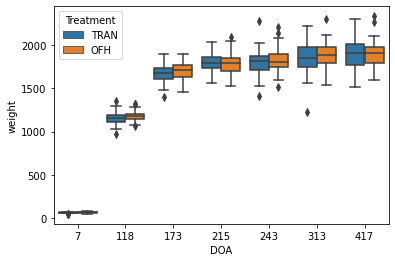

In [32]:
#plt.figure(figsize=(10,10))
#sns.lineplot(x='DOA',y='weight',hue='Treatment', data=df_FB_);
sns.boxplot(x='DOA',y='weight',hue='Treatment', data=df_FB_);

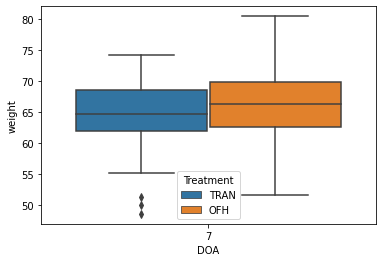

In [33]:
sns.boxplot(x='DOA',y='weight',hue='Treatment', data=df_FB_[df_FB_['DOA']==7]);

In [34]:
df_FB_ = df_FB_[~df_FB_['weight'].isnull()]
print(df_FB_.shape)
df_FB_.to_csv(os.path.join(path_extracted_data, 'OFH_df_FOCALBIRDS.csv'), index=False, sep=',')

(1121, 9)


# Numbers describing the Selection Process in Rearing Barn

In [35]:
#info on selection process: 
#when possible (i.e. enough MEXP in each pens), 25% (resp.25%) of focal bird were selected randomly among the MEXP (resp. LEXP) 
#remaining 50% of focal animals were selected as a representative sample of the population (called here EPI, as part of a larger study
#with epigenetics aanalysis)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(12, 4)


,Treatment,R-Pen,CLASS,HenID
0,OFH,1.0,EPI,20
1,OFH,1.0,LEXP,9
2,OFH,1.0,MEXP,10
3,OFH,3.0,EPI,20
4,OFH,3.0,LEXP,8
5,OFH,3.0,MEXP,9
6,TRAN,2.0,EPI,21
7,TRAN,2.0,LEXP,10
8,TRAN,2.0,MEXP,6
9,TRAN,4.0,EPI,19


In [36]:
#info on selection process: repartition of Rearing pen in laying pen across class
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS',
                                                                                                 'PenID'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(47, 5)


,Treatment,R-Pen,CLASS,PenID,HenID
0,OFH,1.0,EPI,pen_11,5
1,OFH,1.0,EPI,pen_3,5
2,OFH,1.0,EPI,pen_5,5
3,OFH,1.0,EPI,pen_9,5
4,OFH,1.0,LEXP,pen_11,2
5,OFH,1.0,LEXP,pen_3,2
6,OFH,1.0,LEXP,pen_5,3
7,OFH,1.0,LEXP,pen_9,2
8,OFH,1.0,MEXP,pen_11,2
9,OFH,1.0,MEXP,pen_3,3


In [33]:
#info on selection process: repartition of class in laying pen
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','PenID','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(24, 4)


,Treatment,PenID,CLASS,HenID
0,OFH,pen_11,EPI,10
1,OFH,pen_11,LEXP,3
2,OFH,pen_11,MEXP,4
3,OFH,pen_3,EPI,10
4,OFH,pen_3,LEXP,5
5,OFH,pen_3,MEXP,5
6,OFH,pen_5,EPI,10
7,OFH,pen_5,LEXP,4
8,OFH,pen_5,MEXP,5
9,OFH,pen_9,EPI,10


In [34]:
#info on selection process: uniform representation of rearing pen identity (RPenID) in each LPenID
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['PenID','R-Pen'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(16, 3)


,PenID,R-Pen,HenID
0,pen_10,2.0,9
1,pen_10,4.0,10
2,pen_11,1.0,9
3,pen_11,3.0,8
4,pen_12,2.0,10
5,pen_12,4.0,10
6,pen_3,1.0,10
7,pen_3,3.0,10
8,pen_4,2.0,9
9,pen_4,4.0,9


# Available data - In Words

In [35]:
mi = min(df_daily['DOA'].tolist())
ma = max(df_daily['DOA'].tolist())
print('We are involving a period of %d days of tracking during the days from the DOA %d until DOA %d'%(ma-mi, mi, ma))

We are involving a period of 297 days of tracking during the days from the DOA 119 until DOA 416


In [36]:
#check #obs/hen - to be removed due to unexpected issues
df_info = df_daily.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()
df_info['nbrDaysTracked'] = df_info['DOA'].map(lambda x: len(set(x)))
df_info = df_info.sort_values(['nbrDaysTracked'])
display(df_info.head(3))
display(df_info.tail(3))
#pen 5 had issues with batteries of markers!
print(df_info['nbrDaysTracked'].mean())
#df_info[df_info['HenID']=='hen_26']['level'].values

print('hens had in average %d days tracked with a minimum of %d days tracked \
and a max of %d days'%(round(df_info['nbrDaysTracked'].mean(),0),df_info['nbrDaysTracked'].min(),df_info['nbrDaysTracked'].max()))

print('In other words, %d hens were used in subsequent analysis with a total of %d observations.'%(len(df_daily['HenID'].unique()),
                                                                                                   df_daily.shape[0]))

C:\Users\camil\AppData\Local\Temp/ipykernel_15588/3940579085.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_info = df_daily.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()


,HenID,DOA,level,PenID,nbrDaysTracked
34,hen_130,"[124, 125, 126]","[2020-10-05 00:00:00, 2020-10-06 00:00:00, 202...","[pen10, pen10, pen10]",3
36,hen_132,"[119, 120, 121, 125, 126]","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen8, pen8, pen8, pen8, pen8]",5
152,hen_31,"[119, 120, 121, 125, 126]","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen9, pen9, pen9, pen9, pen9]",5


,HenID,DOA,level,PenID,nbrDaysTracked
203,hen_78,"[119, 120, 121, 123, 124, 125, 126, 129, 130, ...","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen10, pen10, pen10, pen10, pen10, pen10, pen...",256
28,hen_124,"[119, 120, 121, 125, 126, 129, 130, 131, 132, ...","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen8, pen8, pen8, pen8, pen8, pen8, pen8, pen...",256
184,hen_60,"[119, 120, 121, 123, 124, 125, 126, 129, 130, ...","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen10, pen10, pen10, pen10, pen10, pen10, pen...",256


173.48898678414096
hens had in average 173 days tracked with a minimum of 3 days tracked and a max of 256 days
In other words, 227 hens were used in subsequent analysis with a total of 39382 observations.


# Available data - In Visuals

In [37]:
#heatmap of the hens, one row per hen: 1 means existing tracked day for the hen
df_plt = df_daily[['HenID', 'PenID', 'Treatment', 'CLASS','level','perc_duration_5_Zone']].copy()
##### find missing days
Daterange = pd.date_range(start = dt.datetime(2020,9,30), end =  dt.datetime(2021,7,25), freq = 'D')    
li_missing_dates = [i for i in Daterange if i not in df_plt['level'].unique()]

##### add one row per missing dates for a random hen with perc_duration_5_Zone beeing np.nan
x = df_plt.iloc[0]
df_missingdate = pd.DataFrame([{'level':d, 'perc_duration_5_Zone':np.nan, 'HenID':x['HenID'], 'PenID':x['PenID'], 
                                'Treatment':x['Treatment'],'CLASS':x['CLASS']} for d in li_missing_dates])
print(df_plt.shape)
df_plt = df_plt.append(df_missingdate, ignore_index=True)
print(df_plt.shape)
df_plt['level'] = df_plt['level'].map(lambda x: dt.datetime.date(x))
df_plt.sort_values(['level'], inplace=True)
li_date = df_plt['level'].unique()

##### say if bird was tracked on taht day or not (i.e. we have his duration in zone 5)
df_plt['Tracked'] = df_plt['perc_duration_5_Zone'].map(lambda x: int(not math.isnan(x)))
display(df_plt.head(3))
df_plt = df_plt.pivot(index=['HenID', 'PenID', 'Treatment', 'CLASS'], columns='level', values='Tracked').reset_index()
df_plt = df_plt.fillna(0)
df_plt.sort_values(['PenID'], inplace=True)
li_henorder = df_plt['HenID'].tolist()
print(df_plt.shape)
df_plt.head(3)

(39382, 6)
(39419, 6)


,HenID,PenID,Treatment,CLASS,level,perc_duration_5_Zone,Tracked
18132,hen_4,pen3,OFH,MEXP,2020-09-30,0.0,1
20931,hen_153,pen4,TRAN,MEXP,2020-09-30,49.0,1
20434,hen_150,pen4,TRAN,LEXP,2020-09-30,100.0,1


(227, 303)


level,HenID,PenID,Treatment,CLASS,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,...,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,2021-07-22,2021-07-23,2021-07-24,2021-07-25
48,hen_143,pen10,TRAN,MEXP,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
118,hen_210,pen10,TRAN,REXP,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
119,hen_211,pen10,TRAN,REXP,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


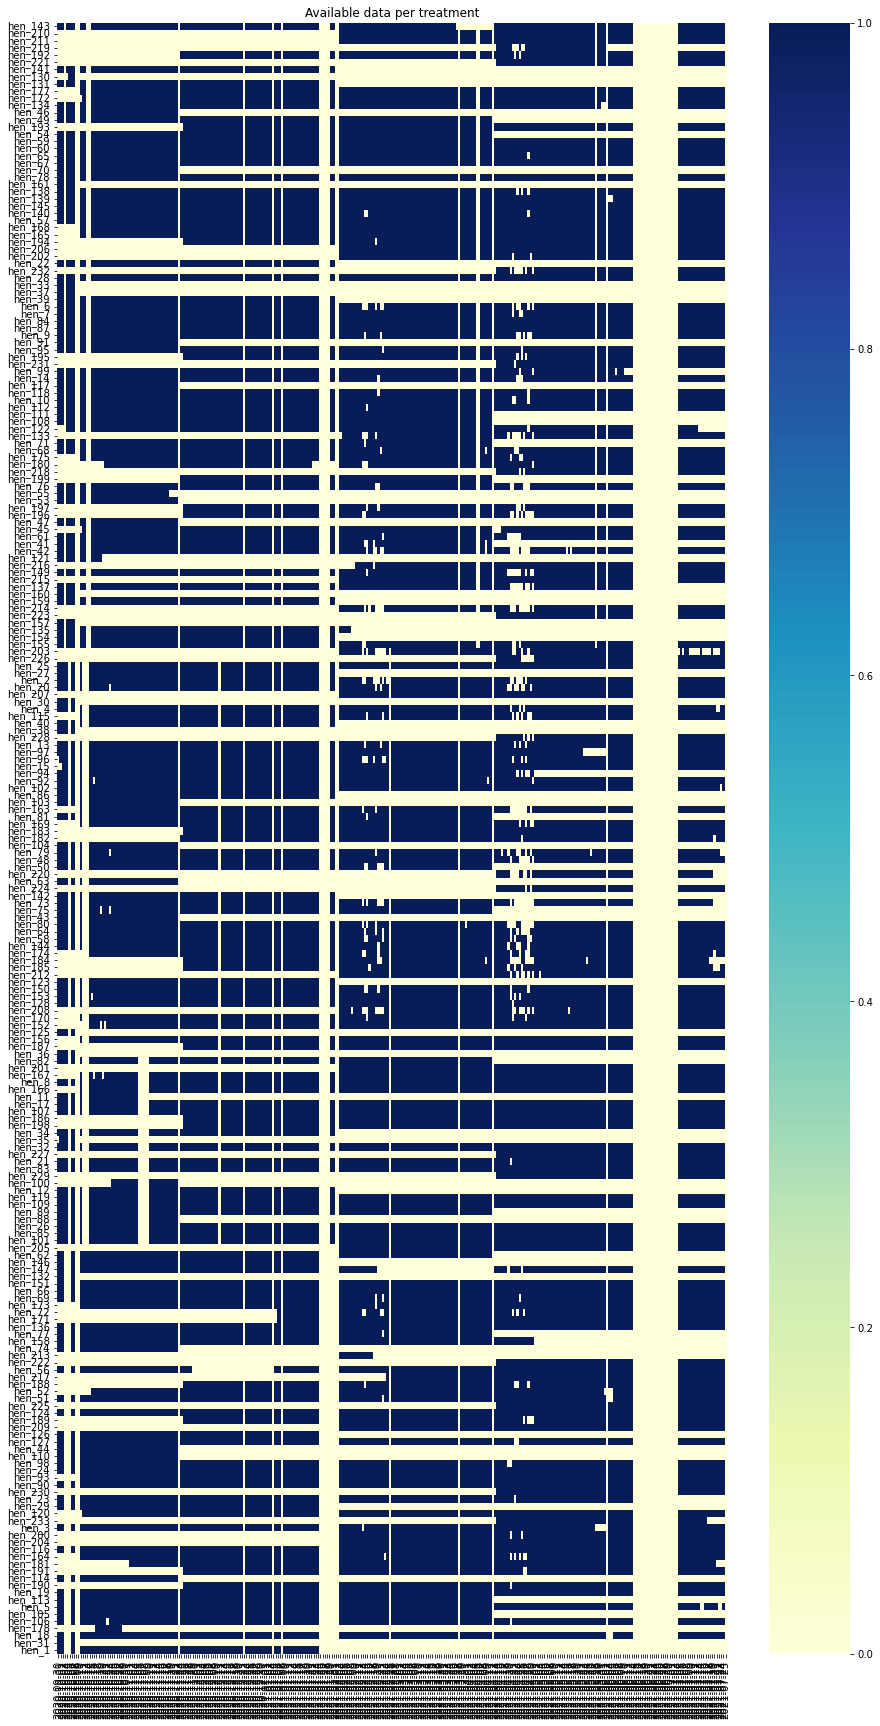

In [38]:
#per hens
fig = plt.figure(figsize=(15,30))
sns.heatmap(df_plt[li_date].to_numpy(), xticklabels=li_date,  yticklabels=df_plt['HenID'].tolist(), cmap="YlGnBu")
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data,name+'_DataPerHens.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

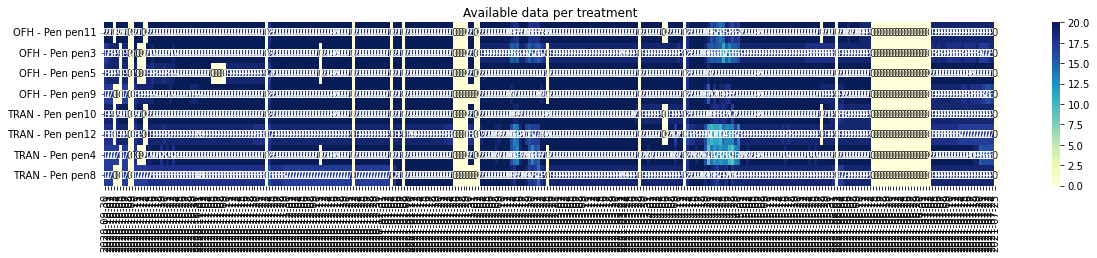

In [39]:
#per treatment
df_plt_summarized = df_plt.groupby(['Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['Treatment']+' - Pen '+str(x['PenID']), axis=1)
fig = plt.figure(figsize=(20,3))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data,name+'_DataPerTreatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

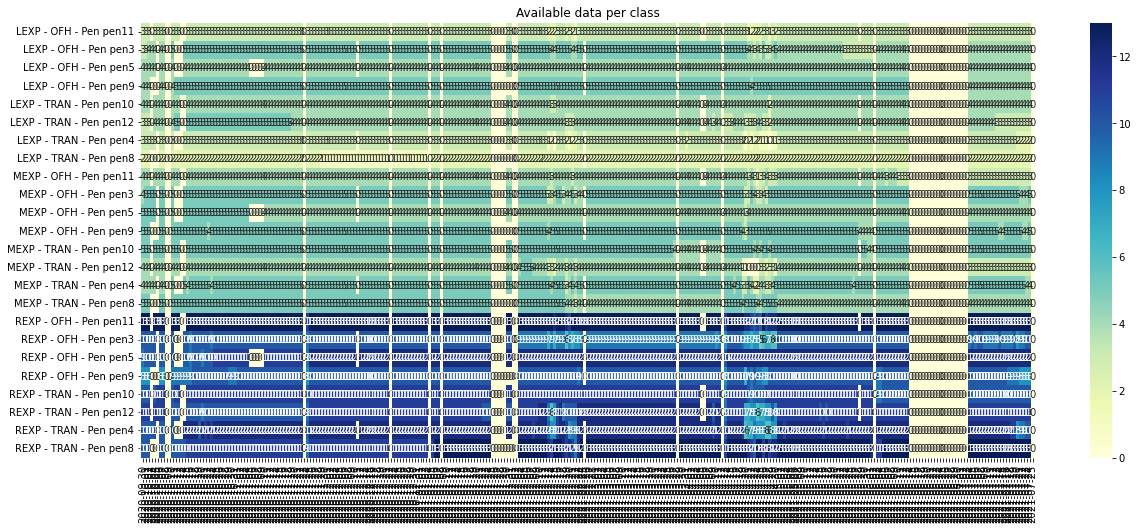

In [40]:
#per class
df_plt_summarized = df_plt.groupby(['CLASS','Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['CLASS']+' - '+x['Treatment']+' - Pen '+str(x['PenID']), 
                                                    axis=1)
fig = plt.figure(figsize=(20,8))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per class')
plt.savefig(os.path.join(path_extracted_data,name+'_DataPerClass.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()